In [2]:
import datetime
import itertools
import json
import os
import time
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from pandas import Series
from scipy.stats.mstats import winsorize
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier)
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from statsmodels.tsa.arima_model import ARIMA

from fbprophet import Prophet

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

## Feature Exploration, Engineering and Cleaning

### Load Datasets

In [3]:
# TODO: 封装到load_datasets.py 里作为一个函数
low_memory = False  # use high memory!
use_feather = True  # 用硬盘换时间

goods_promote_price_path = '../datasets/goods_promote_price.csv'
goods_sku_relation_path = '../datasets/goods_sku_relation.csv'
goodsale_path = '../datasets/goodsale.csv'
goodsdaily_path = '../datasets/goodsdaily.csv'
marketing_path = '../datasets/marketing.csv'
goodsinfo_path = '../datasets/goodsinfo.csv'

goods_promote_price_feather = '../datasets/feathers/goods_promote_price.feather'
goods_sku_relation_feather = '../datasets/feathers/goods_sku_relation.feather'
goodsale_feather = '../datasets/feathers/goodsale.feather'
goodsdaily_feather = '../datasets/feathers/goodsdaily.feather'
marketing_feather = '../datasets/feathers/marketing.feather'
goodsinfo_feather = '../datasets/feathers/goodsinfo.feather'

all_feathers_exist = (Path(goods_promote_price_feather).exists() and
                      Path(goods_sku_relation_feather).exists() and
                      Path(goodsale_feather).exists() and
                      Path(goodsdaily_feather).exists() and
                      Path(marketing_feather).exists() and
                      Path(goodsinfo_feather).exists())
if use_feather and all_feathers_exist:
    goods_promote_price = pd.read_feather(goods_promote_price_feather)
    goods_sku_relation = pd.read_feather(goods_sku_relation_feather)
    goodsale = pd.read_feather(goodsale_feather)
    goodsdaily = pd.read_feather(goodsdaily_feather)
    marketing = pd.read_feather(marketing_feather)
    goodsinfo = pd.read_feather(goodsinfo_feather)
else:
    goods_promote_price = pd.read_csv(
        goods_promote_price_path, low_memory=low_memory, thousands=',')
    goods_sku_relation = pd.read_csv(
        goods_sku_relation_path, low_memory=low_memory, thousands=',')
    goodsale = pd.read_csv(goodsale_path, low_memory=low_memory, thousands=',')
    goodsdaily = pd.read_csv(
        goodsdaily_path, low_memory=low_memory, thousands=',')
    marketing = pd.read_csv(
        marketing_path, low_memory=low_memory, thousands=',')
    goodsinfo = pd.read_csv(
        goodsinfo_path, low_memory=low_memory, thousands=',')
    # Save DataFrames to feathers
    goods_promote_price.to_feather(goods_promote_price_feather)
    goods_sku_relation.to_feather(goods_sku_relation_feather)
    goodsale.to_feather(goodsale_feather)
    goodsdaily.to_feather(goodsdaily_feather)
    marketing.to_feather(marketing_feather)
    goodsinfo.to_feather(goodsinfo_feather)

In [4]:
submission_example_path = '../submissions/submit_example.csv'
submission_example_feather = '../datasets/feathers/submission_example.feather'
if Path(submission_example_feather).exists():
    submission_example = pd.read_feather(submission_example_feather)
else:
    submission_example = pd.read_csv(submission_example_path)
    submission_example.to_feather(submission_example_feather)

### submission_df()

In [5]:
def submission_df(sku_id_num):
    test_df = pd.read_csv(submission_example_path, dtype={
                          'week1': 'float32', 'week2': 'float32', 'week3': 'float32', 'week4': 'float32', 'week5': 'float32'})
    test_df.head(5)
    sub_df = test_df.merge(sku_id_num, on=["sku_id"], how="left")[
        ["sku_id", "goods_num"]]
    sub_df["goods_num"] = sub_df["goods_num"].fillna(0.0).clip(0., 20.)
    sub_df["week1"] = sub_df["goods_num"]
    sub_df["week2"] = sub_df["goods_num"]
    sub_df["week3"] = sub_df["goods_num"]
    sub_df["week4"] = sub_df["goods_num"]
    sub_df["week5"] = sub_df["goods_num"]
    sub_df = sub_df.drop("goods_num", axis=1)
    return sub_df


def create_submission_file(sku_id_num, submission_name="submission", add_timestamp=True):
    if add_timestamp:
        submission_name = "%s_%d" % (submission_name, time.time())

    path = os.path.abspath(os.path.join(
        "../submissions/%s.csv" % submission_name))
    base_dir = os.path.dirname(path)
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    sub_df = submission_df(sku_id_num)
    sub_df.to_csv(path, sep=",", index=False)

In [65]:
# 一个均值submission
mean_result = pd.merge(goodsale, submission_example, how='inner', on=['sku_id'])
X = mean_result.copy()
y = X["sku_id"]
X.drop("sku_id", axis=1)
for col in tqdm(X.columns[X.dtypes=="object"]):
    X[col] = X[col].factorize()[0]

# rf = RandomForestClassifier(verbose=True, n_jobs=1)
# rf.fit(X, y)
xgb_model = xgb.XGBClassifier()
# xgb_model.fit(X_train, y_train)
# ... groupby(sku_id).mean()
mean_submission = pd.DataFrame({
    # 'sku_id': #...`
    # '...' : ...
})

mean_submission.to_csv('../submissions/mean_submission.csv')

### goodsdaily 商品在用户层日常表现

In [67]:
# goodsdaily[['data_date', 'goods_click', 'cart_click', 'favorites_click', 'sales_uv', 'onsale_days']] = goodsdaily[[
#     'data_date', 'goods_click', 'cart_click', 'favorites_click', 'sales_uv', 'onsale_days']].astype(np.int32)
# goodsdaily.to_feather(goodsdaily_feather)

In [137]:
goodsdaily.head(5)

,data_date,goods_id,goods_click,cart_click,favorites_click,sales_uv,onsale_days,day,month,year,weekday,week_number
0,20170823,G8OeZY,72,2,3,0,6,23,8,2017,2,34
1,20170823,Gjytr2,96,0,1,0,336,23,8,2017,2,34
2,20170823,GR0SgC,15,0,0,0,98,23,8,2017,2,34
3,20170823,GMkqxN,9,0,0,0,13,23,8,2017,2,34
4,20170823,GuRXYe,538,5,9,2,69,23,8,2017,2,34


In [69]:
goodsdaily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35201588 entries, 0 to 35201587
Data columns (total 7 columns):
data_date          int32
goods_id           object
goods_click        int32
cart_click         int32
favorites_click    int32
sales_uv           int32
onsale_days        int32
dtypes: int32(6), object(1)
memory usage: 1.0+ GB


In [94]:
# goodsdaily['day'] = pd.to_datetime(goodsdaily['data_date'], format = '%Y%m%d').dt.day
# goodsdaily['month'] = pd.to_datetime(goodsdaily['data_date'], format = '%Y%m%d').dt.month
# goodsdaily['year'] = pd.to_datetime(goodsdaily['data_date'], format = '%Y%m%d').dt.year
# goodsdaily['weekday'] = pd.to_datetime(goodsdaily['data_date'], format = '%Y%m%d').dt.dayofweek
# goodsdaily['week_number'] = pd.to_datetime(goodsdaily['data_date'], format = '%Y%m%d').dt.week

In [95]:
goodsdaily.to_feather(goodsdaily_feather)

In [97]:
goodsdaily.head(20)

,data_date,goods_id,goods_click,cart_click,favorites_click,sales_uv,onsale_days,day,month,year,weekday,week_number
0,20170823,G8OeZY,72,2,3,0,6,23,8,2017,2,34
1,20170823,Gjytr2,96,0,1,0,336,23,8,2017,2,34
2,20170823,GR0SgC,15,0,0,0,98,23,8,2017,2,34
3,20170823,GMkqxN,9,0,0,0,13,23,8,2017,2,34
4,20170823,GuRXYe,538,5,9,2,69,23,8,2017,2,34
5,20170823,G9HciW,3,0,0,0,681,23,8,2017,2,34
6,20170823,G8WYsu,7,0,0,0,16,23,8,2017,2,34
7,20170823,G70ZFA,25,1,0,0,131,23,8,2017,2,34
8,20170823,GK2Qai,1245,44,27,6,82,23,8,2017,2,34
9,20170823,Gm8sNC,17,0,2,0,6,23,8,2017,2,34


In [98]:
goodsdaily.describe(include='all')

,data_date,goods_id,goods_click,cart_click,favorites_click,sales_uv,onsale_days,day,month,year,weekday,week_number
count,3.520159e+07,35201588,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07
unique,NaN,423453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,GCWzpZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.017323e+07,NaN,8.163273e+01,3.240518e+00,1.709665e+00,4.639567e-01,1.704799e+02,1.552970e+01,6.847242e+00,2.017253e+03,3.011738e+00,2.784837e+01
std,4.054337e+03,NaN,3.859332e+02,2.150991e+01,7.565983e+00,3.962768e+00,2.077281e+02,8.726376e+00,3.801863e+00,4.345010e-01,1.993512e+00,1.660725e+01
min,2.017030e+07,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.017000e+03,0.000000e+00,1.000000e+00
25%,2.017073e+07,NaN,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.300000e+01,8.000000e+00,3.000000e+00,2.017000e+03,1.000000e+00,1.100000e+01
50%,2.017103e+07,NaN,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.070000e+02,1.500000e+01,7.000000e+00,2.017000e+03,3.000000e+00,3.000000e+01
75%,2.018010e+07,NaN,4.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00,2.260000e+02,2.300000e+01,1.000000e+01,2.018000e+03,5.000000e+00,4.300000e+01


可以看出, 40w 的商品总共有3500w 条每天数据

In [71]:
# 按天分类, 每天商品销售情况: daily_sum
daily_sum = goodsdaily.groupby('data_date', as_index=False).sum()
daily_sum.head()

,data_date,goods_click,cart_click,favorites_click,sales_uv,onsale_days
0,20170301,4743177,161294,83795,25311,7769402
1,20170302,4519004,152657,81412,23590,7973204
2,20170303,4834336,161606,90559,23713,8019540
3,20170304,5148932,170897,98071,25839,7491376
4,20170305,4914224,163795,89276,25192,7359999


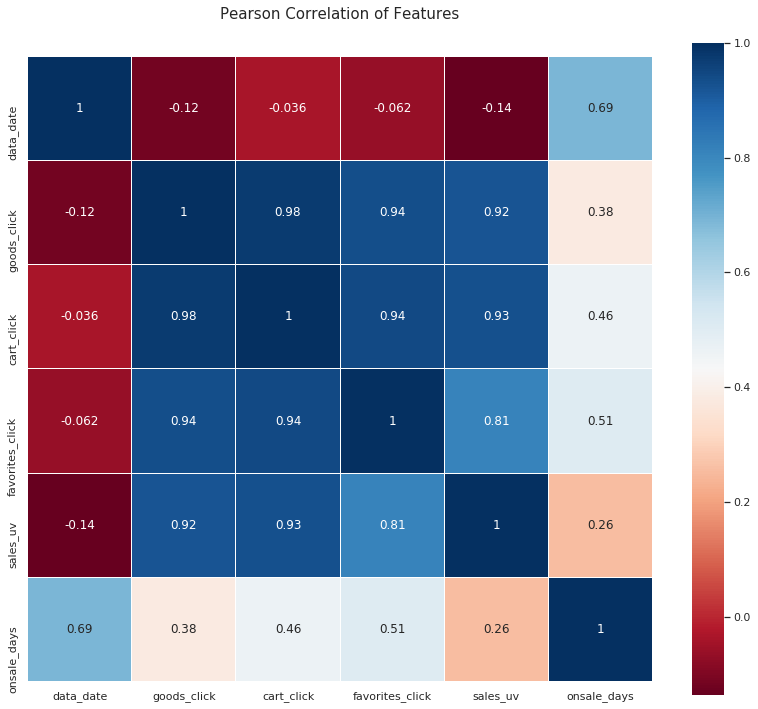

In [72]:
# 看下每天商品销售情况各特征的相关性
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(daily_sum.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

加购和点击量差不多完全线性相关(.98), 而且和销量也基本线性相关(.93), 而收藏量由于延迟等原因没有那么相关(.81)

In [73]:
# TODO: 整合出新 feature: popularity 或者说 user_interest

['data_date' 'goods_click' 'cart_click' 'favorites_click' 'sales_uv'
 'onsale_days']


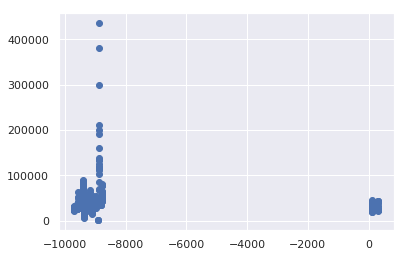

In [74]:
print(daily_sum.columns.values)
plt.scatter(daily_sum['data_date'] - 20180000, daily_sum['sales_uv'])

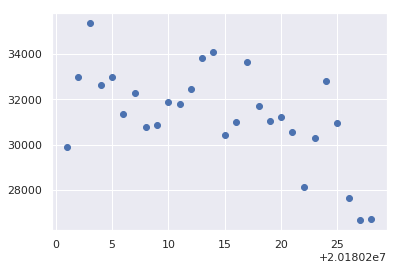

In [75]:
# 挑几个月看下日销售情况
first2mons_daily_sum = daily_sum[(20180200 < daily_sum['data_date']) & \
                                 (daily_sum['data_date'] < 20180300)]
plt.scatter(first2mons_daily_sum['data_date'], first2mons_daily_sum['sales_uv'])

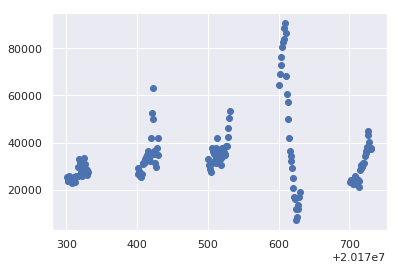

In [76]:
first2mons_daily_sum = daily_sum[(20170300 < daily_sum['data_date']) & \
                                 (daily_sum['data_date'] < 20170800)]
plt.scatter(first2mons_daily_sum['data_date'], first2mons_daily_sum['sales_uv'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c7e191d30>,
      dtype=object)

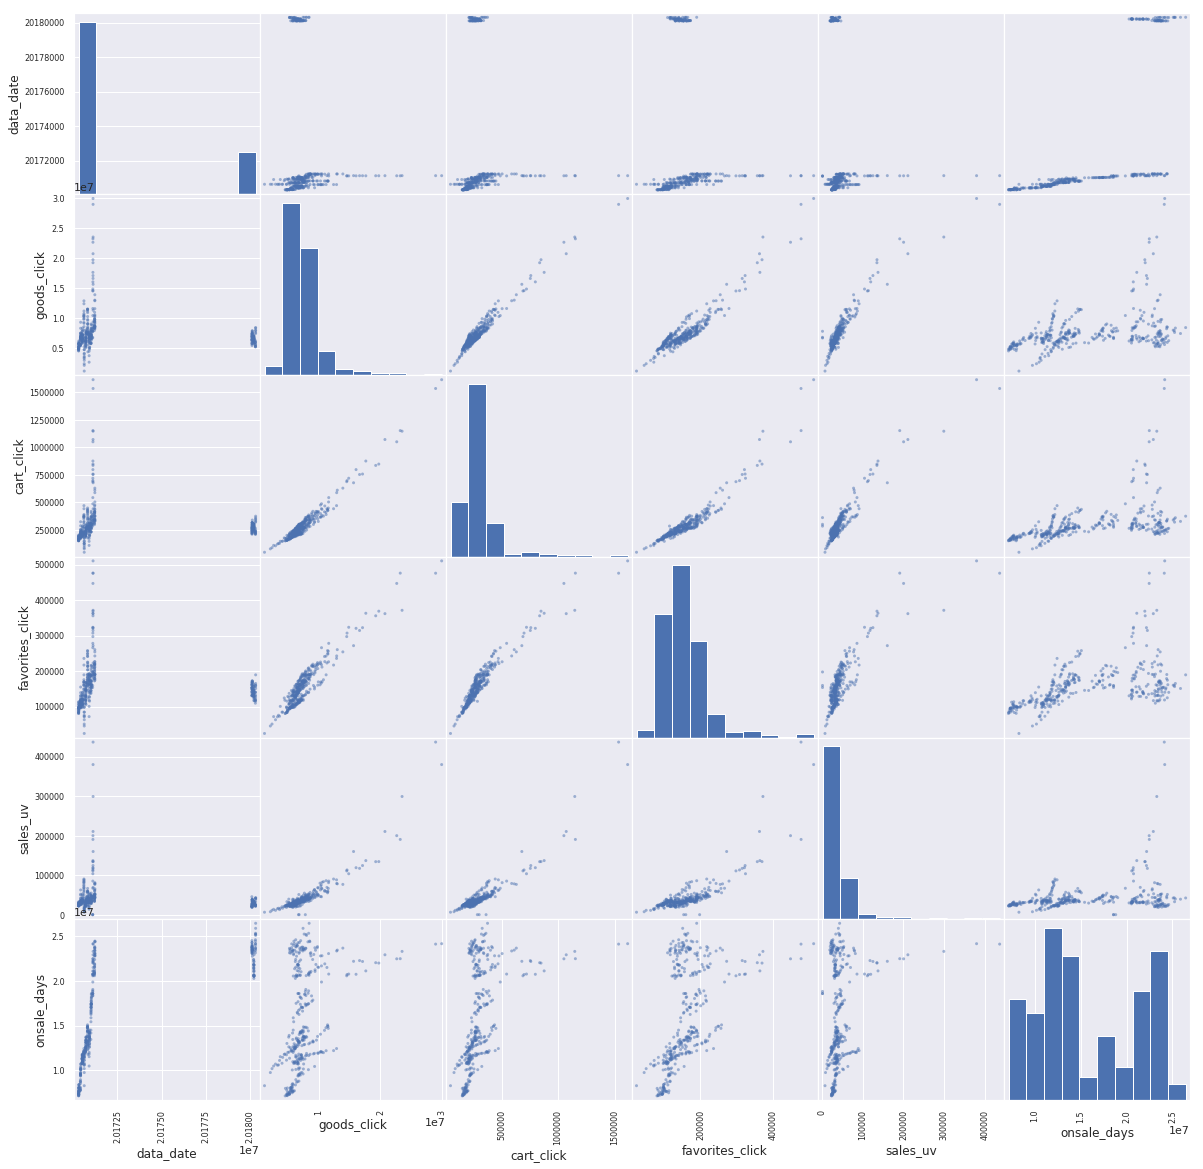

In [77]:
pd.scatter_matrix(frame=daily_sum, figsize=(20, 20))

### goodsinfo 商品信息
商品的一些属性: 类目, 季节属性, 品牌id

In [78]:
goodsinfo.describe(include='all')

,goods_id,cat_level1_id,cat_level2_id,cat_level3_id,cat_level4_id,cat_level5_id,cat_level6_id,cat_level7_id,goods_season,brand_id
count,423452,423452.000000,423452.000000,423452.000000,423452.000000,423452.000000,423452.0,423452.0,423452.000000,423452.000000
unique,423452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,GOCxGm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,584.135057,1936.813084,2561.146871,383.653496,28.033529,-1.0,-1.0,1.213679,483.439719
std,NaN,1206.801739,2289.516917,1832.745418,1170.068380,362.907817,0.0,0.0,1.385024,1270.265420
min,NaN,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,-1.000000
25%,NaN,2.000000,99.000000,666.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.000000
50%,NaN,59.000000,432.000000,2260.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.000000
75%,NaN,364.000000,3650.000000,4226.000000,-1.000000,-1.000000,-1.0,-1.0,2.000000,0.000000


In [79]:
goodsinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423452 entries, 0 to 423451
Data columns (total 10 columns):
goods_id         423452 non-null object
cat_level1_id    423452 non-null int64
cat_level2_id    423452 non-null int64
cat_level3_id    423452 non-null int64
cat_level4_id    423452 non-null int64
cat_level5_id    423452 non-null int64
cat_level6_id    423452 non-null int64
cat_level7_id    423452 non-null int64
goods_season     423452 non-null int64
brand_id         423452 non-null int64
dtypes: int64(9), object(1)
memory usage: 32.3+ MB


### goodsale 商品销售数据
每日sku, 价格

In [12]:
goodsale["data_date"] = goodsale.data_date.map(lambda data:str(data))
goodsale["date"] = pd.to_datetime(goodsale.data_date)

In [13]:
goodsale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7325028 entries, 0 to 7325027
Data columns (total 12 columns):
data_date             object
goods_id              object
sku_id                object
goods_num             int64
goods_price           float64
orginal_shop_price    float64
day                   int64
month                 int64
year                  int64
weekday               int64
week_number           int64
date                  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 670.6+ MB


In [14]:
goodsale.describe(include='all')


,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price,day,month,year,weekday,week_number,date
count,7325028,7325028,7325028,7.325028e+06,7.325028e+06,7.325028e+06,7.325028e+06,7.325028e+06,7.325028e+06,7.325028e+06,7.325028e+06,7325028
unique,381,195498,630742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,381
top,20171125,G9tnlg,SK4taRSU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-25 00:00:00
freq,79185,4905,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79185
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-16 00:00:00
mean,NaN,NaN,NaN,2.227298e+00,1.252557e+01,2.004515e+01,1.598098e+01,7.138575e+00,2.017171e+03,3.044103e+00,2.915236e+01,NaN
std,NaN,NaN,NaN,5.272697e+00,1.014520e+01,1.447311e+01,8.559107e+00,3.571323e+00,3.766943e-01,2.007197e+00,1.564892e+01,NaN
min,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.017000e+03,0.000000e+00,1.000000e+00,NaN
25%,NaN,NaN,NaN,1.000000e+00,5.990000e+00,1.099000e+01,9.000000e+00,4.000000e+00,2.017000e+03,1.000000e+00,1.500000e+01,NaN


In [15]:
goodsale.head(10)

,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price,day,month,year,weekday,week_number,date
0,20170518,GIxOHa,SKg8D0d7,1,1.99,1.99,18,5,2017,3,20,2017-05-18
1,20171219,GfvDCS,SKzkS30M,1,10.99,15.99,19,12,2017,1,51,2017-12-19
2,20170427,GrwmCH,SKDZNsaw,3,30.99,44.99,27,4,2017,3,17,2017-04-27
3,20170720,GIbEyJ,SKZAlwv2,2,6.99,14.99,20,7,2017,3,29,2017-07-20
4,20170906,G3B1xG,SKlIemMi,1,9.99,12.99,6,9,2017,2,36,2017-09-06
5,20170308,Gy8BSH,SKCDfdcA,1,13.99,23.99,8,3,2017,2,10,2017-03-08
6,20171030,G8Cg3L,SKzsyOI2,1,15.99,23.99,30,10,2017,0,44,2017-10-30
7,20170830,GNzfF8,SKE3Rm8a,2,16.99,16.99,30,8,2017,2,35,2017-08-30
8,20180308,GE7DLW,SKhseGSf,1,11.99,24.99,8,3,2018,3,10,2018-03-08
9,20170626,GrwmCH,SKwyIpX5,1,33.99,44.99,26,6,2017,0,26,2017-06-26


In [16]:
# goodsale['day'] = pd.to_datetime(goodsale['data_date'], format = '%Y%m%d').dt.day
# goodsale['month'] = pd.to_datetime(goodsale['data_date'], format = '%Y%m%d').dt.month
# goodsale['year'] = pd.to_datetime(goodsale['data_date'], format = '%Y%m%d').dt.year
# goodsale['weekday'] = pd.to_datetime(goodsale['data_date'], format = '%Y%m%d').dt.dayofweek
# goodsale['week_number'] = pd.to_datetime(goodsale['data_date'], format = '%Y%m%d').dt.week
goodsale.to_feather(goodsale_feather)
goodsale_2018 = goodsale[goodsale.year==2018]
goodsale_2018.describe(include='all')

,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price,day,month,year,weekday,week_number,date
count,1254134,1254134,1254134,1.254134e+06,1.254134e+06,1.254134e+06,1.254134e+06,1.254134e+06,1254134.0,1.254134e+06,1.254134e+06,1254134
unique,75,98152,243995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75
top,20180101,GClf8c,SKdJ2X8y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00
freq,23120,1356,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23120
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-16 00:00:00
mean,NaN,NaN,NaN,1.933297e+00,1.173121e+01,1.976443e+01,1.425266e+01,1.809048e+00,2018.0,2.919130e+00,5.965264e+00,NaN
std,NaN,NaN,NaN,3.112817e+00,1.220168e+01,1.637475e+01,8.454368e+00,7.698108e-01,0.0,1.996068e+00,3.079771e+00,NaN
min,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2018.0,0.000000e+00,1.000000e+00,NaN
25%,NaN,NaN,NaN,1.000000e+00,4.990000e+00,9.990000e+00,7.000000e+00,1.000000e+00,2018.0,1.000000e+00,3.000000e+00,NaN


In [132]:
goodsale_2018_week5_11 = goodsale_2018[(
    goodsale_2018.week_number >= 5) & (goodsale_2018.week_number <= 11)]
goodsale_2018week5_11_per_week = goodsale_2018_week5_11.groupby(
    ["sku_id"], as_index=False).goods_num.sum()
goodsale_2018week5_11_per_week["goods_num"] /= 7. 
df = submission_df(goodsale_2018week5_11_per_week)
# create_submission_file(goodsale_2018_week5_11)
# goodsale_2018week5_11_per_week.head(30)
# df.head(30)
# df.to_csv('../submissions/mean_submission.csv', index=False)

### goods_sku_relation (纯 map, 没有预测意义)
总共 320w 不同的 sku, 42w 不同的商品

In [82]:
goods_sku_relation.describe(include='all')

,sku_id,goods_id
count,3245170,3245170
unique,3245170,423453
top,SKhsyci0,GAnJO3
freq,1,266


### goods_promote_price 促销价
加两列 start_time, end_time: 用来转换 promote_start_time, promote_end_time 成 int 型, 方便计算

In [83]:

# tqdm.pandas()
if 'start_time' not in goods_promote_price.columns:
    goods_promote_price['start_time'] = goods_promote_price['promote_start_time'].apply(
        lambda x: int("".join(x.split(" ")[0].split("-"))))

if 'end_time' not in goods_promote_price.columns:
    goods_promote_price['end_time'] = goods_promote_price['promote_end_time'].apply(
        lambda x: int("".join(x.split(" ")[0].split("-"))))

goods_promote_price.head()

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time,start_time,end_time
0,20180129,GBLrYn,289.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101
1,20180129,GfrkEb,17.99,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101
2,20180129,GD8pMl,412.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101
3,20180129,Gfid4P,87.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101
4,20180129,Gzjk0i,43.99,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101


In [84]:

goods_promote_price.describe(include='all')

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time,start_time,end_time
count,2.401643e+07,24016430,2.401643e+07,2.401643e+07,24016430,24016430,2.401643e+07,2.401643e+07
unique,NaN,423453,NaN,NaN,955,1008,NaN,NaN
top,NaN,GcN73G,NaN,NaN,1970-01-01 08:00:00,1970-01-01 08:00:00,NaN,NaN
freq,NaN,60,NaN,NaN,15273827,15272969,NaN,NaN
mean,2.018022e+07,NaN,3.837252e+01,7.274269e+00,NaN,NaN,1.987316e+07,1.987458e+07
std,6.789219e+01,NaN,5.922209e+01,1.518260e+01,NaN,NaN,2.287823e+05,2.306283e+05
min,2.018012e+07,NaN,0.000000e+00,0.000000e+00,NaN,NaN,1.970010e+07,1.970010e+07
25%,2.018013e+07,NaN,1.899000e+01,0.000000e+00,NaN,NaN,1.970010e+07,1.970010e+07
50%,2.018022e+07,NaN,2.999000e+01,0.000000e+00,NaN,NaN,1.970010e+07,1.970010e+07
75%,2.018030e+07,NaN,4.299000e+01,1.199000e+01,NaN,NaN,2.017122e+07,2.018021e+07


In [85]:
goods_promote_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24016430 entries, 0 to 24016429
Data columns (total 8 columns):
data_date             int64
goods_id              object
shop_price            float64
promote_price         float64
promote_start_time    object
promote_end_time      object
start_time            int64
end_time              int64
dtypes: float64(2), int64(3), object(3)
memory usage: 1.4+ GB


In [86]:
# 看有没有错误促销
goods_promote_price[goods_promote_price['shop_price'] < goods_promote_price['promote_price']]

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time,start_time,end_time


不存在 标价<促销价, 还行

In [87]:

if 'is_promoted' not in goods_promote_price.columns:
    # 加 is_promoted 列 表示是否为促销产品
    goods_promote_price['is_promoted'] = 0
    is_promoted = (goods_promote_price['promote_price'] > .0) & \
        (goods_promote_price['start_time'] < goods_promote_price['data_date']) & \
        (goods_promote_price['end_time'] > goods_promote_price['data_date'])

    goods_promote_price.loc[is_promoted, 'is_promoted'] = 1

In [88]:
goods_promote_price.head()

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time,start_time,end_time,is_promoted
0,20180129,GBLrYn,289.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101,0
1,20180129,GfrkEb,17.99,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101,0
2,20180129,GD8pMl,412.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101,0
3,20180129,Gfid4P,87.00,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101,0
4,20180129,Gzjk0i,43.99,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,19700101,19700101,0


现在用 goods_promote_price 这个表给 goods_id + data_date 查询就可以用 is_promoted 判断某个商品在某天是不是促销

### marketing: 平台活动时间表
活动类型, 节奏类型

## Spilit dataset 用 timeseriessplit 的方法或者和 id-based 结合
比如moving window validation

## simple ts model


In [40]:
# daily_goodsale = goodsale.groupby(["date"])["goods_num"].sum().reset_index()
daily_goodsale = goodsale[goodsale['sku_id']=='SKY0RuBE'].reset_index()
# train = submission_example.merge(goodsale, on=["sku_id"], how="left")

In [41]:
# train = train[["sku_id", "data_date", "goods_num"]]
train = daily_goodsale[["date", "goods_num"]]
train = train.rename(columns = {'date': 'ds',
                                'goods_num': 'y'})
train.head(10)

,ds,y
0,2017-12-25,2
1,2017-11-26,8
2,2018-01-07,1
3,2017-12-21,3
4,2017-11-11,2
5,2017-11-29,1
6,2017-10-22,1
7,2018-01-23,1
8,2017-12-12,1
9,2017-12-14,2


In [42]:
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(train)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
future = model.make_future_dataframe(periods=80)
future.tail()

,ds
133,2018-05-30
134,2018-05-31
135,2018-06-01
136,2018-06-02
137,2018-06-03


In [64]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
133,2018-05-30,0.954272,-0.681978,2.524541
134,2018-05-31,1.267815,-0.469466,2.962271
135,2018-06-01,1.072202,-0.584391,2.712609
136,2018-06-02,1.684092,0.087465,3.321908
137,2018-06-03,1.696208,0.164090,3.457361


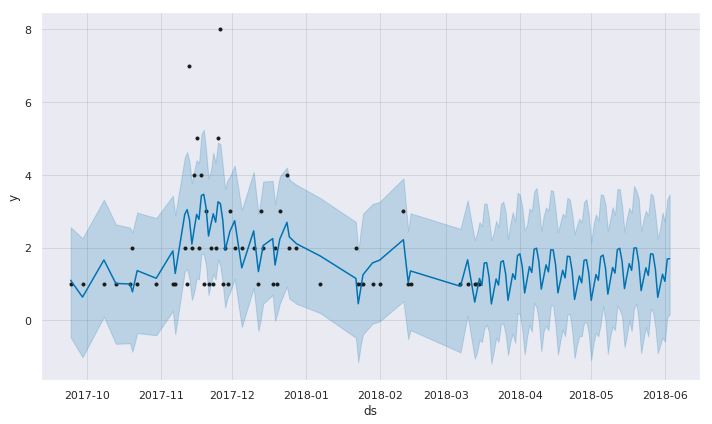

In [65]:
fig1 = model.plot(forecast)

TypeError: scatter() missing 1 required positional argument: 'y'

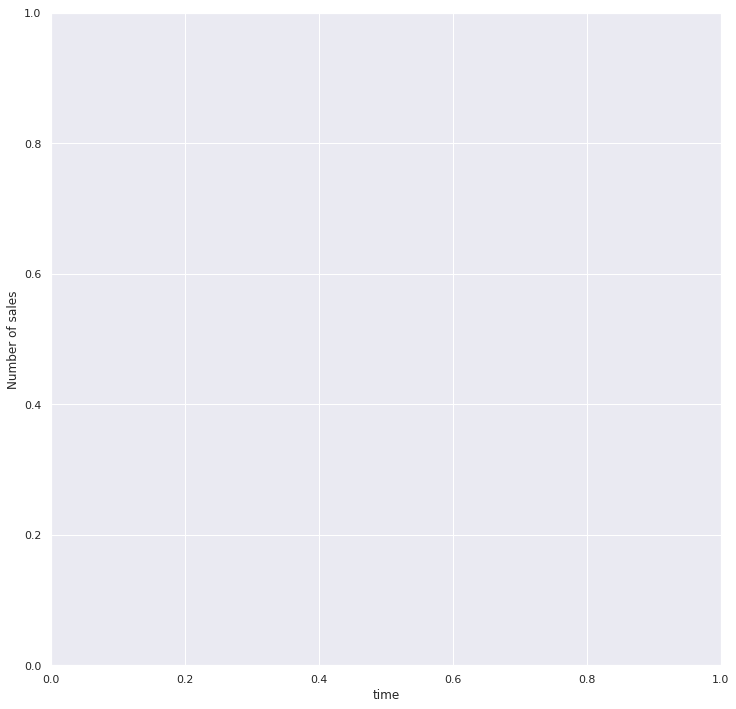

In [66]:
ts = daily_goodsale[['date', 'goods_num']].set_index('date')
plt.figure(figsize=(12,12))
plt.xlabel('time')
plt.ylabel('Number of sales')
plt.scatter(ts);

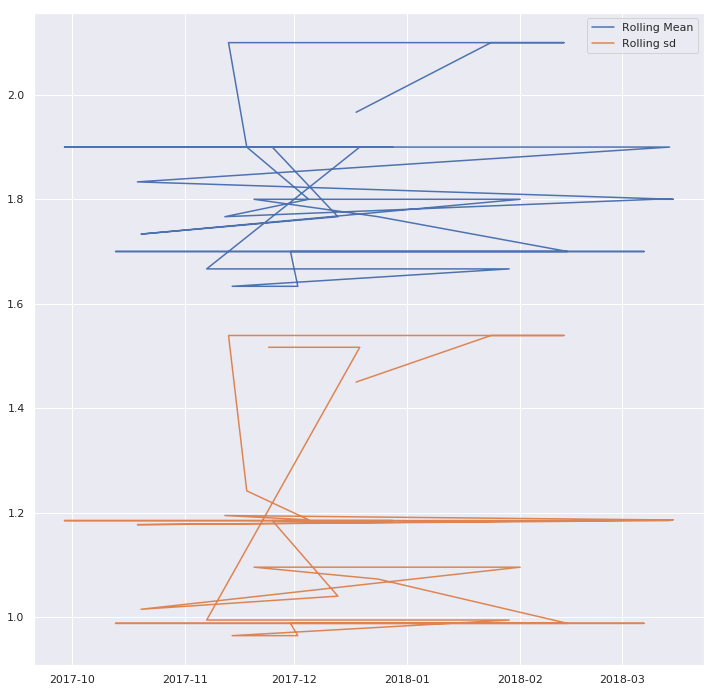

In [47]:
plt.figure(figsize=(12,12))
plt.plot(ts.rolling(window=30,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=30,center=False).std(),label='Rolling sd');
plt.legend();

In [48]:
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic

ts.head()

,goods_num
date,
2017-12-25,2
2017-11-26,8
2018-01-07,1
2017-12-21,3
2017-11-11,2


In [61]:
# from pandas.plotting import autocorrelation_plot
# plt.figure(figsize=(12,6))
# autocorrelation_plot(ts);
# plt.figure(figsize=(12,6))
# autocorrelation_plot(ts);
# plt.xlim(xmax=100);
# plt.figure(figsize=(12,6))
# autocorrelation_plot(ts);
# plt.xlim(xmax=10);

In [54]:
# goodsale = goodsale.rename(columns = {'orginal_shop_price': 'original_price'})
# goodsale.head()

,data_date,goods_id,sku_id,goods_num,goods_price,original_price,day,month,year,weekday,week_number,date,on_sale
0,20170518,GIxOHa,SKg8D0d7,1,1.99,1.99,18,5,2017,3,20,2017-05-18,0
1,20171219,GfvDCS,SKzkS30M,1,10.99,15.99,19,12,2017,1,51,2017-12-19,0
2,20170427,GrwmCH,SKDZNsaw,3,30.99,44.99,27,4,2017,3,17,2017-04-27,0
3,20170720,GIbEyJ,SKZAlwv2,2,6.99,14.99,20,7,2017,3,29,2017-07-20,0
4,20170906,G3B1xG,SKlIemMi,1,9.99,12.99,6,9,2017,2,36,2017-09-06,0


In [57]:
# goodsale['on_sale'] = 0
# goodsale.loc[goodsale['goods_price']<goodsale['original_price'], 'on_sale'] = 1 

In [58]:
# goodsale.to_feather(goodsale_feather)

In [60]:
goodsale.head()

,data_date,goods_id,sku_id,goods_num,goods_price,original_price,day,month,year,weekday,week_number,date,on_sale
0,20170518,GIxOHa,SKg8D0d7,1,1.99,1.99,18,5,2017,3,20,2017-05-18,0
1,20171219,GfvDCS,SKzkS30M,1,10.99,15.99,19,12,2017,1,51,2017-12-19,1
2,20170427,GrwmCH,SKDZNsaw,3,30.99,44.99,27,4,2017,3,17,2017-04-27,1
3,20170720,GIbEyJ,SKZAlwv2,2,6.99,14.99,20,7,2017,3,29,2017-07-20,1
4,20170906,G3B1xG,SKlIemMi,1,9.99,12.99,6,9,2017,2,36,2017-09-06,1
